# Benchmarking of various implementations of FADDEEVA's error functions

## I. Setup

In [2]:
import numpy as np
from numpy.ctypeslib import ndpointer
import scipy
import ctypes
import sys

The dictionary `wofz_impl` accesses the various function implementations.

Input interface is `wofz_impl[<implementation-folder>](x, y)`: 
`x` is the real and `y` is the imaginary part of the input, both should be numpy arrays (i.e. provide the ctypes field).

In [3]:
wofz_impl = dict()

For argument types needing double pointers, use the ctypes pointer provided by NumPy:

In [4]:
np_double_p = ndpointer(dtype=np.float64)

`ctypes` libraries are loaded into the dictionary `dlls`:

In [5]:
dlls = dict()

### scipy

http://ab-initio.mit.edu/wiki/index.php/Faddeeva_Package

In [6]:
from scipy.special import wofz as scipy_wofz

prepare the `wofz_impl` entry:

In [7]:
def wofz(x, y):
    z = scipy_wofz(x + 1j*y)
    return z.real, z.imag
wofz_impl['scipy'] = wofz

### cernlib-c-1

loading the external shared C library:

In [8]:
dlls['c-1'] = ctypes.cdll.LoadLibrary('cernlib-c-1/wofz.so')
dlls['c-1'].errf.restype = None
dlls['c-1'].errf.argtypes = [np_double_p, np_double_p, np_double_p, np_double_p]

prepare the `wofz_impl` entry:

In [9]:
def wofz(x, y):
    in_real = np.atleast_1d(x).astype(np.float64)
    in_imag = np.atleast_1d(y).astype(np.float64)
    out_real = np.empty(1, dtype=np.float64)
    out_imag = np.empty(1, dtype=np.float64)
    dlls['c-1'].errf(in_real, in_imag, out_real, out_imag)
    return out_real[0], out_imag[0]
wofz_impl['c-1'] = wofz

### cernlib-c-2

loading the external shared C library:

In [10]:
dlls['c-2'] = ctypes.cdll.LoadLibrary('cernlib-c-2/wofz.so')
dlls['c-2'].cerrf.restype = None
dlls['c-2'].cerrf.argtypes = [ctypes.c_double, ctypes.c_double, np_double_p, np_double_p]

prepare the `wofz_impl` entry:

In [11]:
def wofz(x, y):
    in_real = ctypes.c_double(x)
    in_imag = ctypes.c_double(y)
    out_real = np.empty(1, dtype=np.float64)
    out_imag = np.empty(1, dtype=np.float64)
    dlls['c-2'].cerrf(in_real, in_imag, out_real, out_imag)
    return out_real[0], out_imag[0]
wofz_impl['c-2'] = wofz

### cernlib-cuda-1

try whether PyCUDA is available for the CUDA FADDEEVA version:

In [12]:
i_pycuda = False
try:
    from pycuda.autoinit import context
    from pycuda import gpuarray
    from pycuda.elementwise import ElementwiseKernel
    i_pycuda = True
except ImportError as e:
    print 'No PyCUDA available, as per error message:'
    print e.message

prepare the CUDA kernel for the wofz function:

In [13]:
if i_pycuda:
    kernel = ElementwiseKernel(
        'double* in_real, double* in_imag, double* out_real, double* out_imag',
#         'out_real[i] = in_real[i]; out_imag[i] = in_imag[i]',
        'wofz(in_real[i], in_imag[i], &out_real[i], &out_imag[i]);',
        'wofz_kernel',
        preamble=open('cernlib-cuda-1/wofz.cu', 'r').read()
    )

prepare the `wofz_impl` entry:

In [14]:
if i_pycuda:
    def wofz(x, y):
        in_real = gpuarray.to_gpu(np.atleast_1d(x).astype(np.float64))
        in_imag = gpuarray.to_gpu(np.atleast_1d(y).astype(np.float64))
        out_real = gpuarray.empty(1, dtype=np.float64)
        out_imag = gpuarray.empty(1, dtype=np.float64)
        kernel(in_real, in_imag, out_real, out_imag)
        return out_real.get()[0], out_imag.get()[0]
    wofz_impl['cuda'] = wofz

### cernlib-f90-1

import and numpy-vectorise the first f90 version:

In [15]:
sys.path.append('cernlib-f90-1')
from wwerf import ccperrfr

wofz_impl['f90-1'] = np.vectorize(ccperrfr)

### cernlib-f90-2

import and numpy-vectorise the second f90 version:

In [16]:
sys.path.append('cernlib-f90-2')
from wwerf2 import errf

wofz_impl['f90-2'] = np.vectorize(errf)

### cernlib-python-1

In [26]:
sys.path.append('cernlib-python-1')
from mywwerf import wwerf

wofz_impl['py'] = np.vectorize(wwerf)

### high precision library for error function

to be added

# II. Accuracy Benchmark

## dirty hands-on, just trying what happens:

In [18]:
wofz_impl['scipy'](3, 2)

(0.092710766426443436, 0.12831696222826169)

In [19]:
wofz_impl['c-1'](3, 2)

(0.17737693471415558, 0.30315008341851968)

### ^^^!!! cernlib-c-1 produces weird stuff. I (Adrian) found some differences compared to cernlib-c-2 but this does not seem to be all yet!

In [20]:
wofz_impl['c-2'](3, 2)

(0.092710766426443145, 0.12831696222826672)

In [21]:
wofz_impl['cuda'](3, 2)

(0.092710766426443145, 0.12831696222826672)

In [22]:
wofz_impl['f90-1'](3, 2)

(array(0.09271077124408933), array(0.12831696889616245))

In [23]:
wofz_impl['f90-2'](3, 2)

(array(0.09271076642644314), array(0.12831696222826672))

In [24]:
wofz_impl['py'](3, 2)

(0.057634864776266663, 0.035177087006951484)

### ^^^ I guess this is due to being outside of the applicable limits of this approximation implementation

.

.

.

.

## plots from benchmark.py

In [29]:
from pylab import *
%matplotlib inline
wsci = wofz_impl['scipy']
wf90 = wofz_impl['f90-1']
wf = wofz_impl['f90-2']
wpy = wofz_impl['py']

/home/oeftiger/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:33: RuntimeWarning: divide by zero encountered in log10


1.2286989111690166e-08

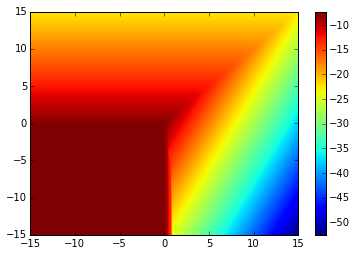

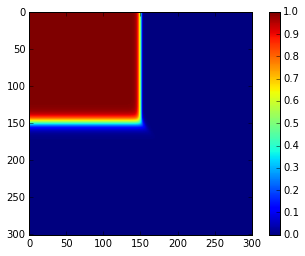

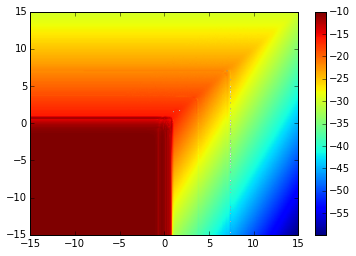

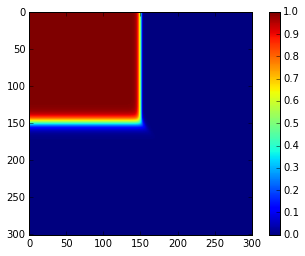

In [31]:
#https://github.com/PyCOMPLETE/PyHEADTAIL/master/spacecharge/spacecharge.py

#http://www.bigdft.org/devel-doc/d0/dfa/wofz_8f90_source.html
#http://www.bigdft.org/devel-doc/d0/dfa/wofz_8f90.html
#http://dl.acm.org/citation.cfm?id=77629
# latest
#www.ccsenet.org/journal/index.php/jmr/article/viewFile/41877/24151 
# http://ab-initio.mit.edu/wiki/index.php/Faddeeva_Package
# arxiv.org/pdf/1407.0748 In root with source code


r=15
xx=10**linspace(-r,r,301)
yy=10**linspace(-r,r,301)
x,y=meshgrid(xx,yy)

x1,y1=wsci(x,y)
x2,y2=wf90(x,y)
x3,y3=wf(x,y)

clf();
imshow(log10(abs(x1-x2)),origin="bottom",extent=[-r,r,-r,r],aspect='auto')
colorbar()


figure()
clf();imshow(x1);colorbar()
figure()
clf();imshow(x2);colorbar()


clf();
imshow(log10(abs(x1-x3)),origin="bottom",extent=[-r,r,-r,r],aspect='auto')
colorbar()
figure()
clf();imshow(x3);colorbar()

ref90=[ (x,y)+wf90(x,y) for x in xx for y in yy]
repy =[ (x,y)+wpy(x,y)  for x in xx for y in yy]
resci=[ (x,y)+wsci(x,y) for x in xx for y in yy]

(array(ref90)-array(resci)).std()

<matplotlib.colorbar.Colorbar instance at 0x7f4277a89bd8>

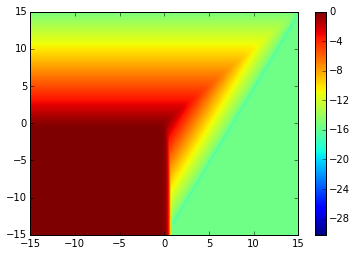

In [34]:
x_c2, y_c2 = np.vectorize(wofz_impl['c-2'])(x, y)
imshow(log10(abs(x1-x_c2)),origin="bottom",extent=[-r,r,-r,r],aspect='auto')
colorbar()

# III. Timing Benchmark

to be provided